# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [1]:
import os
import tqdm
import glob
%pip install PyPDF2
from PyPDF2 import PdfReader
%pip install langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter
%pip install sentence-transformers
from sentence_transformers import SentenceTransformer
%pip install langchain-community
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
%pip install longchain-community.embeddings
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
%pip install faiss-cpu
import faiss
import pickle
import matplotlib.pyplot as plt
%pip install umap-learn
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
%pip install groq
from groq import Groq


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement longchain-community.embeddings (from versions: none)
ERROR: No matching distribution found for longchain-community.embeddings


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [2]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:01,  7.51it/s]

<_io.BufferedReader name='data\\02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data\\05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>
<_io.BufferedReader name='data\\Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>


 33%|███▎      | 3/9 [00:00<00:00, 13.83it/s]

<_io.BufferedReader name='data\\Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data\\W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:01<00:01,  3.52it/s]

<_io.BufferedReader name='data\\ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  2.15it/s]

<_io.BufferedReader name='data\\Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  2.35it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:02<00:00,  2.22it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [3]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [4]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [6]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [7]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [8]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

C:\Users\lucac\AppData\Local\Temp\ipykernel_24604\4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [10]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [11]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [12]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [13]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [14]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


c:\Users\lucac\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings: 100%|██████████| 252/252 [00:04<00:00, 52.30it/s] 


Projected dataset embeddings shape: (252, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [16]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [17]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [18]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings: 100%|██████████| 1/1 [00:00<00:00, 200.16it/s]


## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

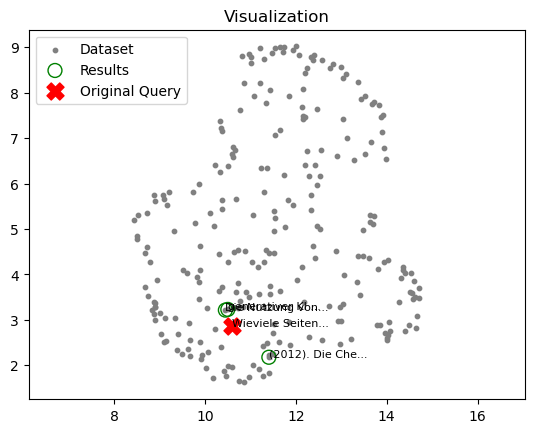

In [19]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [20]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.

In [21]:

#  Modell laden & Query definieren
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("Sahajtomar/German-semantic")
query = "Welche Regeln gelten für den Einsatz von KI bei Bachelorarbeiten?"


# Anfrage einbetten & vorbereiten
query_embedding = model.encode(query, convert_to_numpy=True)
query_vector = np.array([query_embedding], dtype="float32")


# Ähnliche Chunks über FAISS abrufen
k = 3  # Anzahl zurückgegebener Chunks
distances, indices = index.search(query_vector, k)


# Chunks & Embeddings extrahieren
retrieved_texts = [token_split_texts[i] for i in indices[0] if 0 <= i < len(token_split_texts)]
retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0] if 0 <= i < len(chunk_embeddings)])


# Ausgabe der Ergebnisse
if not retrieved_texts:
    print("Keine passenden Textstellen gefunden.")
else:
    for i, text in enumerate(retrieved_texts):
        print(f"--- Treffer {i+1} ---\n{text[:300]}...\n")


print("Indices:", indices[0])
print("Chunks gesamt:", len(token_split_texts))


--- Treffer 1 ---
pflicht von generativer KI bei Arbeiten oder kontaktieren Ihre Do- zentin oder Ihren Dozenten . Hat Ihr Studiengang oder Dozent:in für Ihre Arbeit Regeln bezüglich Einsatz generativer KI -Tools festgelegt? Ja Es gelten die Anweisungen Ihrer Dozentin oder...

--- Treffer 2 ---
generativer KI bei Arbeiten Version: 1.2.0 gültig ab: 01.03.2025 Seite 1 von 5 Rektorat Ressort Bildung Verwendung von generativer KI bei Arbeiten Dieses Merkblatt basiert auf : − Richtlinie KI bei Leistungsnachweisen − ergänzender Anhang 1. Grundsatz Grundsätzlich gilt, dass die Verwendung von gene...

--- Treffer 3 ---
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei...

Indices: [181 178 155]
Chunks gesamt: 252


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

In [22]:
# Kontextblock aus den abgerufenen Chunks
context_block = "\n\n".join(retrieved_texts)

# Prompt-Vorlage
prompt = f"""Beantworte die folgende Frage basierend auf dem gegebenen Kontext.

Kontext:
{context_block}

Frage:
{query}
"""

# (Optional) Vorschau anzeigen
print("Prompt-Vorschau:\n")
print(prompt[:1000])  # nur die ersten 1000 Zeichen anzeigen

Prompt-Vorschau:

Beantworte die folgende Frage basierend auf dem gegebenen Kontext.

Kontext:
pflicht von generativer KI bei Arbeiten oder kontaktieren Ihre Do- zentin oder Ihren Dozenten . Hat Ihr Studiengang oder Dozent:in für Ihre Arbeit Regeln bezüglich Einsatz generativer KI -Tools festgelegt? Ja Es gelten die Anweisungen Ihrer Dozentin oder

generativer KI bei Arbeiten Version: 1.2.0 gültig ab: 01.03.2025 Seite 1 von 5 Rektorat Ressort Bildung Verwendung von generativer KI bei Arbeiten Dieses Merkblatt basiert auf : − Richtlinie KI bei Leistungsnachweisen − ergänzender Anhang 1. Grundsatz Grundsätzlich gilt, dass die Verwendung von generativen KI -Tools bei Arbeiten zu de- klarieren ist. Dieses Merkblatt hilft Ihnen Schritt -für-Schritt bei der korrekten Umset- zung. 2. Pflichten im Umgang Ihre Pflichten im Umgang mit generativer KI − Sie tragen Verantwortung für die Qualität der Inhalte : Auch

(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15.

In [25]:
from dotenv import load_dotenv
from groq import Groq
import os

# API-Key laden
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

# Groq-Client initialisieren
groq_client = Groq(api_key=groq_api_key)

# Prompt senden
response = groq_client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0,
    max_tokens=200,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# Antwort anzeigen
answer = response.choices[0].message.content
print("Antwort vom LLM:\n")
print(answer)


Antwort vom LLM:

Laut dem gegebenen Kontext gibt es keine allgemeinen Regeln, die den Einsatz von KI bei Bachelorarbeiten verbieten. Stattdessen gilt, dass die Verwendung von generativen KI-Tools bei Arbeiten zu deklarieren ist. Die genauen Regeln können jedoch von der jeweiligen Hochschule oder dem Dozenten festgelegt werden.

Es wird erwähnt, dass die Richtlinie KI bei Leistungsnachweisen der Zürcher Hochschule für Angewandte Wissenschaften (ZHAW) den Umgang mit KI regelt, aber ein Verbot generativer KI-Systeme bei der Erstellung von Arbeiten ist nicht vorgesehen.

Um genauere Informationen zu erhalten, sollten Sie daher Ihre Dozentin oder Ihren Dozenten kontaktieren, um zu erfahren, ob es spezifische Regeln für Ihren Studiengang oder Ihre Arbeit gibt.


In [ ]:
%pip install groq
from dotenv import load_dotenv
from groq import Groq
import os

# 🔐 API-Key laden
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

# 🤖 Groq-Client erstellen
groq_client = Groq(api_key=groq_api_key)

# 🧠 Beispiel-Query
query = "What is the most important factor in diagnosing asthma?"

# ➕ Kontext-Block aus vorherigen Chunks (retrieved_texts)
context = "\n\n".join(retrieved_texts)

# ✍️ Prompt bauen
prompt = f"""Answer the following question based on the provided context.

Context:
{context}

Question:
{query}
"""

# 📤 Prompt an Groq senden
response = groq_client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0.2,
    max_tokens=300,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# ✅ Antwort anzeigen
answer = response.choices[0].message.content
print("💬 Antwort vom LLM:\n")
print(answer)

Note: you may need to restart the kernel to use updated packages.


GroqError: The api_key client option must be set either by passing api_key to the client or by setting the GROQ_API_KEY environment variable

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


In [27]:
# beispiel-Query
query = "What is the most important factor in diagnosing asthma?"
#anfrage einbetten
query_embedding = model.encode(query, convert_to_numpy=True)
#ähnliche Chunks abrufen
query_vector = np.array([query_embedding], dtype="float32")
distances, indices = index.search(query_vector, k=3)
# chunks extrahieren
retrieved_texts = [token_split_texts[i] for i in indices[0]]
# prompt-Vorlage
context = "\n".join(retrieved_texts)
prompt = f"""Answer the following question based on the provided context.

Context:
{context}

Question:
{query}
"""
#an groq senden
response = groq_client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0,
    max_tokens=200,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)
#antworten
answer = response.choices[0].message.content
print("💬 Antwort vom LLM:\n")
print(answer)

💬 Antwort vom LLM:

The provided context does not mention the diagnosis of asthma or any related factors. The context appears to be a citation guide with examples of different reference formats, and it includes a mention of a U.S. Food and Drug Administration publication on smoking cessation products. Therefore, it is not possible to determine the most important factor in diagnosing asthma based on the provided context.
